In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
cd /content/drive/My\ Drive

/content/drive/My Drive


In [0]:
# !unzip PlantVillage.zip 

In [25]:
!pip install tensorflow-gpu keras tensorflow-hub

In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [0]:
ls

'AI Hackathon'/    data.ipynb      PlantVillage.zip
 categories.json   PlantVillage/   Untitled0.ipynb


In [0]:
zip_file=tf.keras.utils.get_file(origin='https://storage.googleapis.com/plantdata/PlantVillage.zip', 
 fname='PlantVillage.zip', extract=True)
#Create the training and validation directories
data = os.path.dirname('PlantVillage/')
data_dir = os.path.join(os.path.dirname(zip_file), 'PlantVillage')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

In [6]:
os.listdir(train_dir)

['Squash___Powdery_mildew',
 'Apple___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Tomato___Target_Spot',
 'Peach___Bacterial_spot',
 'Grape___Esca_(Black_Measles)',
 'Cherry_(including_sour)___healthy',
 'Apple___Apple_scab',
 'Peach___healthy',
 'Tomato___Leaf_Mold',
 'Tomato___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Apple___Black_rot',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Raspberry___healthy',
 'Tomato___healthy',
 'Soybean___healthy',
 'Tomato___Tomato_mosaic_virus',
 'Blueberry___healthy',
 'Strawberry___healthy',
 'Corn_(maize)___Common_rust_',
 'Potato___healthy',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Corn_(maize)___healthy',
 'Tomato___Septoria_leaf_spot',
 'Strawberry___Leaf_scorch',
 'Cherry_(including_sour)___

In [0]:
!wget https://raw.githubusercontent.com/obeshor/Plant-Diseases-Detector/master/categories.json -O categories.json

--2020-01-30 12:17:42--  https://raw.githubusercontent.com/obeshor/Plant-Diseases-Detector/master/categories.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2196 (2.1K) [text/plain]
Saving to: ‘categories.json’

categories.json     100%[===================>]   2.14K  --.-KB/s    in 0s      

2020-01-30 12:17:43 (40.4 MB/s) - ‘categories.json’ saved [2196/2196]



In [34]:
import json
with open('categories.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
print (classes)
num_classes = len(classes)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [39]:
pixels = 224
FV_SIZE = 1280
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16

model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                  input_shape=IMAGE_SIZE+(3,),
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])                                   
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_6 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dropout_9 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               655872    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 38)                19494     
Total params: 2,933,350
Trainable params: 675,366
Non-trainable params: 2,257,984
_________________________________________________________________


In [40]:
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 10861 images belonging to 38 classes.
Found 43444 images belonging to 38 classes.


In [0]:
LEARNING_RATE = 0.001
model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [42]:
EPOCHS=2
STEPS_EPOCHS = train_generator.samples//train_generator.batch_size
VALID_STEPS=validation_generator.samples//validation_generator.batch_size
history = model.fit( 
          train_generator,
          steps_per_epoch=STEPS_EPOCHS,
          epochs=EPOCHS,
          validation_data=validation_generator,
          validation_steps=VALID_STEPS)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 2715 steps, validate for 678 steps
Epoch 1/2
2715/2715 [==============================] - 127s 47ms/step - loss: 0.5142 - accuracy: 0.8415 - val_loss: 0.2493 - val_accuracy: 0.9169
Epoch 2/2
2715/2715 [==============================] - 122s 45ms/step - loss: 0.3161 - accuracy: 0.8971 - val_loss: 0.1987 - val_accuracy: 0.9339


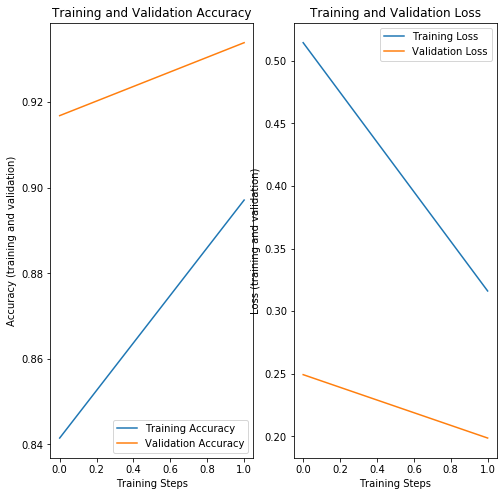

In [43]:
import matplotlib.pylab as plt
import numpy as np
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

SOURCE: class: Potato___Early_blight, file: Potato___Early_blight/f7db505f-aabe-4b96-b719-8c930b5ff471___RS_Early.B 9224.JPG
PREDICTED: class: Potato___Late_blight, confidence: 0.876561


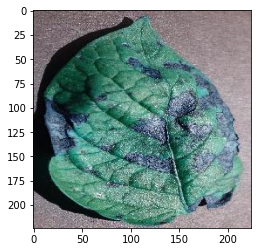

<Figure size 432x288 with 0 Axes>

SOURCE: class: Potato___Early_blight, file: Potato___Early_blight/a0d8a499-e9e4-4c88-829c-7c2270073735___RS_Early.B 8525.JPG
PREDICTED: class: Potato___Late_blight, confidence: 0.999230


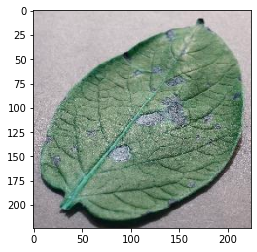

SOURCE: class: Tomato___Spider_mites Two-spotted_spider_mite, file: Tomato___Spider_mites Two-spotted_spider_mite/9115f047-1373-48de-9c60-d62e71c99586___Com.G_SpM_FL 8896.JPG
PREDICTED: class: Tomato___Spider_mites Two-spotted_spider_mite, confidence: 0.622938


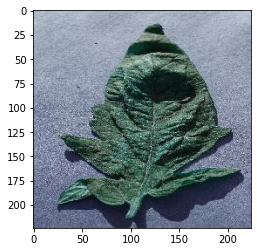

<Figure size 432x288 with 0 Axes>

SOURCE: class: Soybean___healthy, file: Soybean___healthy/0e26c0d3-9869-4e68-a285-c7c051a6a4ed___RS_HL 5559 1.JPG
PREDICTED: class: Soybean___healthy, confidence: 0.999999


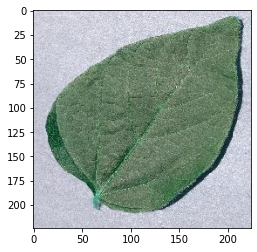

<Figure size 432x288 with 0 Axes>

SOURCE: class: Apple___healthy, file: Apple___healthy/f864bef8-0fb1-43e1-866f-a1e78336be9f___RS_HL 7521.JPG
PREDICTED: class: Apple___healthy, confidence: 0.998943


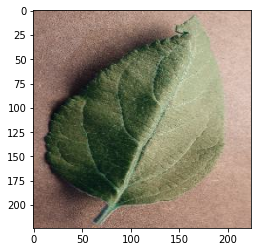

<Figure size 432x288 with 0 Axes>

In [44]:
import cv2
# Utility
import itertools
import random
from collections import Counter
from glob import iglob
def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img
def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [0]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
tf.keras.models.save_model(
    model,
    'model.h5')